In [1]:
import tensorflow as tf
import random
from numba import jit
import os
import csv
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import matplotlib.image as mpimg

In [2]:
tf.__version__

'2.1.0'

# Compétition Kaggle : Image segmentation pour la production d'acier

# Load to memory

### PATHS and DIRECTORIES

In [3]:
# get local variables
local_path = os.getcwd()
data_path = os.path.join(local_path,'data/')

# data directories
train_dir = os.path.join(data_path,'train_images/')
validation_dir = os.path.join(data_path,'validation_images/')

# csv files 
train_csv = os.path.join(data_path,'train.csv')
validation_csv = os.path.join(data_path,'validation.csv')

# mask directories
masks_train_dir = os.path.join(data_path,'train_masks/')
masks_validation_dir = os.path.join(data_path,'validation_masks/')

### Fonctions de conversion

In [4]:
from preprocessing import *

### Load descrition dictionnaries to memory

In [5]:
# On créer les dictionnaires importants
train_descriptions = CSV_to_descriptions(train_csv)
validation_descriptions = CSV_to_descriptions(validation_csv)

### Example

ef24da2ba
2.0


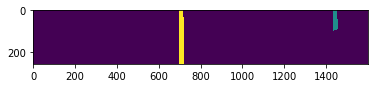

(256, 1600, 3)


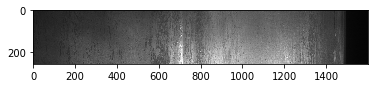

In [6]:
##plot random images with their segmentations

# select random image
img_number = random.randint(0,len(train_descriptions.keys())-1)
img_name = list(train_descriptions.keys())[img_number]
img_name = 'ef24da2ba'
print(img_name)
#img = mpimg.imread(os.path.join(TRAINING_DIR,img_name))
#plot image
description_to_image(img_name,train_descriptions,train_dir,True)

Un rapide calcul nous montre qu'il est impossible de charger en mémoire toutes les images. En effet, bien qu'elles soient toutes compréssée pour tenir dans 2.5Go, les outputs, mêmes codés en 8 bits, prendraient 15 Go de mémoire vive. On va donc se contenter de créer une fonction qui retourne un vecteur avec un mask. 


## Final fonction

In [7]:
def image_to_mask(description_dict, img_name):
    return description_to_image(img_name,description_dict)

In [8]:
def image_to_mask_4(description_dict, img_name):
    return description_to_image_4(img_name,description_dict)

In [9]:
print(image_to_mask(train_descriptions,'ef24da2ba').max())
print(image_to_mask(train_descriptions,'ef24da2ba').shape)
print(image_to_mask_4(train_descriptions,'ef24da2ba').shape)

2.0
(256, 1600)
(256, 1600, 4)


# Generator

On commence par une première version simplifiée. On va réduire les data_sets pour réduire le poids en mémoire. De plus on va uniquement programmer en CPU. Les améliorations se succèderont ensuite. 
Images : $256\times1600\times3$


In [10]:
class generator:
    def __init__(self,descriptions_dict,image_directory):
        self.descriptions_dict = descriptions_dict
        self.image_directory = image_directory
        self.IMG_WIDTH = 256
        self.IMG_LENGTH = 256
        self.number_random_crop = 1600//256 +1
        
    def gen_series(self):
        for img_name in self.descriptions_dict.keys():
            for j in range(self.number_random_crop):
                img,mask = self.random_crop(img_name)
                img,mask = self.preprocessing(img,mask)
                yield img,mask
            
            
    def preprocessing(self,img,mask):
        img = img/255
        # add image augmentation here later
        return img,mask
    
    def random_crop(self,img_name):
        x0 = random.randint(0,1600-256-1)
        img = self.real_image(img_name)
        mask = self.real_mask(img_name)
        return img[:,x0:x0+256,:],mask[:,x0:x0+256,:]
        
    def real_image(self,img_name):
        return tf.cast(np.array(mpimg.imread(os.path.join(self.image_directory,img_name+'.jpg'))),tf.float32)
    
    def real_mask(self,img_name):
        return tf.cast(image_to_mask_4(self.descriptions_dict,img_name),tf.float32)
    

In [11]:
train_generator = generator(train_descriptions,train_dir)
validation_generator = generator(validation_descriptions,validation_dir)

train_ds = tf.data.Dataset.from_generator(
    train_generator.gen_series,
    output_types = (tf.float32,tf.float32),
    output_shapes = (tf.TensorShape([256,256,3]), tf.TensorShape([256,256,4]))
) 
# attention validation différent de test
validation_ds = tf.data.Dataset.from_generator(
    validation_generator.gen_series,
    output_types = (tf.float32,tf.float32),
    output_shapes = (tf.TensorShape([256,256,3]), tf.TensorShape([256,256,4]))
) 

In [12]:
train_ds = train_ds.batch(32)
validation_ds = validation_ds.batch(32)

In [13]:
train_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name=None))

# Création du modèle

In [14]:
# import all layers
from tensorflow.keras.layers import *

In [15]:
def pick(double,tolerance):
    "choose if 1 or 0 tolerance should be 0.5"
    if double > tolerance and double <=1:
        return 1
    elif double >=0 and double <=1:
        return 0
    else :
        print('erreur dans la probabilité, voir loss ')
        
pick_vecteur = np.vectorize(pick,excluded = ['tolerance'])

def dice_coefficient(y_true,y_pred,tolerance = 0.5 ):
    "metric function"
    
    intersection = pick_vecteur(y_true*y_pred,tolerance)
    intersection = 2*np.sum(intersection)
    
    if np.sum(y_true) == 0 and np.sum(y_pred)==0 :
        return 1
    else :
        return intersection/(np.sum(y_pred)+np.sum(y_true))
    
def jaccard_distance(y_true, y_pred, smooth=100):
    "loss function"
    
    intersection = np.sum((y_true * y_pred))
    sum_ = np.sum(y_true+y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [16]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = tf.keras.Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(4, 1, activation = 'softmax')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)
    
    loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    
    optimizer_object = tf.keras.optimizers.Adam()

    model.compile(optimizer = optimizer_object, loss = loss_object, metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [17]:
model = unet()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet.hdf5',monitor = 'loss', verbose =1, save_best_only = True)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [19]:
model.fit(train_ds,epochs =3,steps_per_epoch = 2, callbacks = [model_checkpoint])

Train for 2 steps
Epoch 1/3
1/2 [==============>...............] - ETA: 31s - loss: 0.0032 - accuracy: 0.1422
Epoch 00001: loss improved from inf to 0.01229, saving model to unet.hdf5
2/2 [==============================] - 63s 31s/step - loss: 0.0123 - accuracy: 0.0714
Epoch 2/3
1/2 [==============>...............] - ETA: 29s - loss: 0.0000e+00 - accuracy: 0.1140
Epoch 00002: loss improved from 0.01229 to 0.00131, saving model to unet.hdf5
2/2 [==============================] - 61s 30s/step - loss: 0.0013 - accuracy: 0.5520
Epoch 3/3
1/2 [==============>...............] - ETA: 29s - loss: 0.0000e+00 - accuracy: 0.9900
Epoch 00003: loss improved from 0.00131 to 0.00000, saving model to unet.hdf5
2/2 [==============================] - 61s 30s/step - loss: 0.0000e+00 - accuracy: 0.9899


# Post Processing

In [57]:
def predict(input_image_name,image_directory):
    "predict of an image by its name"
    input_image = mpimg.imread(os.path.join(image_directory,input_image_name+'.jpg'))
    input_image = np.expand_dims(input_image,axis = 0)
    input_image = np.array(input_image,dtype = np.float32)
    
    output_image = np.zeros((1,256,0,4))
    for x0 in range(1600//256):
        
        pred = model.predict(input_image[:,:,x0*256:(x0+1)*256,:])
        
        output_image = np.concatenate((output_image,pred),axis =2)
    
    pred = model.predict(input_image[:,:,1600-256:1600,:])
    
    output_image = np.concatenate((output_image,pred[:,:,256-1600%256:256,:]), axis =2)
    
    return output_image
    

In [58]:
pred = predict('ef24da2ba',train_dir)


In [65]:
def verif(input_image_name,image_directory,dict_descriptions):
    "Des verifications permettant de verifier ce que fait le predict"
    
    prediction_image = predict(input_image_name,image_directory)
    reality_image =np.expand_dims(image_to_mask_4(dict_descriptions,input_image_name),axis = 0)
    print(prediction_image.shape,reality_image.shape)
    print("somme de la prediction" ,np.sum(prediction_image))
    print("somme de la realité", np.sum(reality_image))
    print("difference des deux", np.sum(reality_image-prediction_image))
    
    #rajouter ensuite pour chaque défaut
    

In [66]:
verif('ef24da2ba',train_dir,train_descriptions)


(1, 256, 1600, 4) (1, 256, 1600, 4)
somme de la prediction 409600.0182243454
somme de la realité 732.0
difference des deux -408868.0182243454


In [23]:
# we will predict this image

image_directory = join(os.getcwd(),'data','train_images/')
input_image_name = 'ef24da2ba'

input_image = mpimg.imread(os.path.join(image_directory,input_image_name+'.jpg'))
input_image = np.expand_dims(input_image,axis = 0)
input_image = np.array(input_image,dtype = np.float32)
input_image = input_image[:,:,0:256,:]
pred = model.predict(input_image)

pred.shape

(1, 256, 256, 4)